## Live Ocean West Boundary Conditions

In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [10]:
year = 2017
month = 1
day = 1
single = xr.open_dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y{year}m{month:02d}d{day:02d}.nc')
single

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 1, xbT: 950, yb: 1)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-01-01T12:00:00
  * deptht        (deptht) float64 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * yb            (yb) int64 1
  * xbT           (xbT) int64 0 1 2 3 4 5 6 7 ... 943 944 945 946 947 948 949
Data variables:
    vosaline      (time_counter, deptht, yb, xbT) float64 ...
    votemper      (time_counter, deptht, yb, xbT) float64 ...
    NO3           (time_counter, deptht, yb, xbT) float64 ...
    Si            (time_counter, deptht, yb, xbT) float64 ...
    OXY           (time_counter, deptht, yb, xbT) float64 ...
    DIC           (time_counter, deptht, yb, xbT) float64 ...
    TA            (time_counter, deptht, yb, xbT) float64 ...
Attributes:
    acknowledgements:      Live Ocean http://faculty.washington.edu/pmacc/LO/...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               Temperature, Salinity, Nitrate, Oxygen, DIC and TA...
    source:                http://nbviewer.jupyter.org/urls/bitbucket.org/sal...
    history:               [2019-05-16] File creation.

In [11]:
variables = list(single.keys())
variables

['vosaline', 'votemper', 'NO3', 'Si', 'OXY', 'DIC', 'TA']

In [ ]:
# to make this simplier we will broadcast the original, single arrays to 95, 10 then make the double arrays 190, 20, then recombine

In [25]:
ozsize = single.deptht.shape[0]
zsize = 2*single.deptht.shape[0]
tsize = single.time_counter.shape[0]
xbTsize = 2*2*single.xbT.shape[0]
ysize = 190
xsize = 20

In [2]:
omesh = xr.open_dataset('../../grid/mesh_mask202108.nc')
odeptht = omesh.gdept_1d[0]

<xarray.Dataset>
Dimensions:       (t: 1, x: 796, y: 1796, z: 80)
Dimensions without coordinates: t, x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    tmask         (t, z, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    ...            ...
    gdepv         (t, z, y, x) float32 ...
    gdepw_0       (t, z, y, x) float32 ...
    gdept_1d      (t, z) float64 ...
    gdepw_1d      (t, z) float64 ...
    e3t_1d        (t, z) float64 ...
    e3w_1d        (t, z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  19/06/2022 17:50:57 -0700


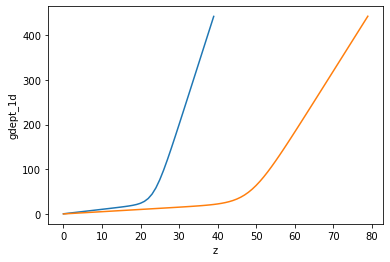

In [3]:
mesh = xr.open_dataset('../../grid/mesh_mask_double_202206.nc')
print (mesh)
deptht = mesh.gdept_1d[0]
omesh.gdept_1d[0].plot()
mesh.gdept_1d[0].plot();

In [16]:
def duplicate_copy(single, tsize, zsize, ysize, xsize):
    double = np.zeros((tsize, zsize, ysize, xsize))
    double[:, 0::2, 0::2, 0::2] = single[:]
    double[:, 1::2, 0::2, 0::2] = single[:] 
    double[:, 0::2, 1::2, 0::2] = single[:]
    double[:, 1::2, 1::2, 0::2] = single[:] 
    double[:, 0::2, 0::2, 1::2] = single[:]
    double[:, 1::2, 0::2, 1::2] = single[:] 
    double[:, 0::2, 1::2, 1::2] = single[:]
    double[:, 1::2, 1::2, 1::2] = single[:] 
    return double

In [4]:
def duplicate_interpolate(single, zsize, xsize, ysize, ozsize, deptht, odeptht):
    double = np.zeros((zsize, ysize, xsize))
    io = 0
    for inew in range(zsize):
        while io < odeptht.shape[0]-1 and deptht[inew] > odeptht[io]:
            io = io + 1
        if deptht[inew] == odeptht[io]:
            double[inew, 0::2, 0::2] = single[io]
        else: 
            if io == 0:
                topi, boti = 0, 1
            else:
                topi, boti = io-1, io
            slope = (single[boti] - single[topi]) / (odeptht[boti] - odeptht[topi])
            intercept = single[boti] - slope * odeptht[boti]
            double[inew, 0::2, 0::2] = intercept + slope * deptht[inew]
    double[:, 1::2, 0::2] = double[:, 0::2, 0::2]
    double[:, 0::2, 1::2] = double[:, 0::2, 0::2]
    double[:, 1::2, 1::2] = double[:, 0::2, 0::2]
    return double

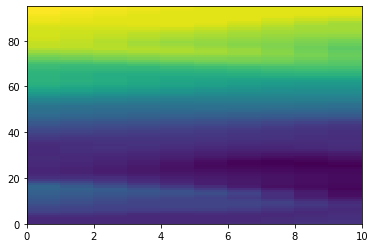

In [24]:
newarray = np.reshape(np.array(single.vosaline[0, :, 0, :]), [40, 95, 10], order='F')
plt.pcolormesh(newarray[5])

In [36]:
vosaline = np.reshape(duplicate_interpolate(np.reshape(np.array(single.vosaline[0, :, 0, :]), [40, 95, 10], order='F'), zsize, xsize, ysize, ozsize, np.array(deptht), np.array(odeptht)),
                      [80, 1, 3800], order='F')
vosaline.shape

(80, 1, 3800)

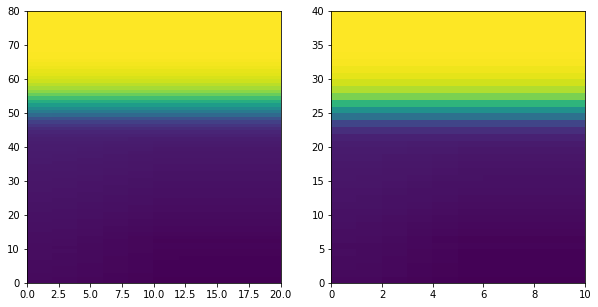

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(vosaline[:, 0, 94*2::190])
axs[1].pcolormesh(single.vosaline[0, :, 0, 94::95])

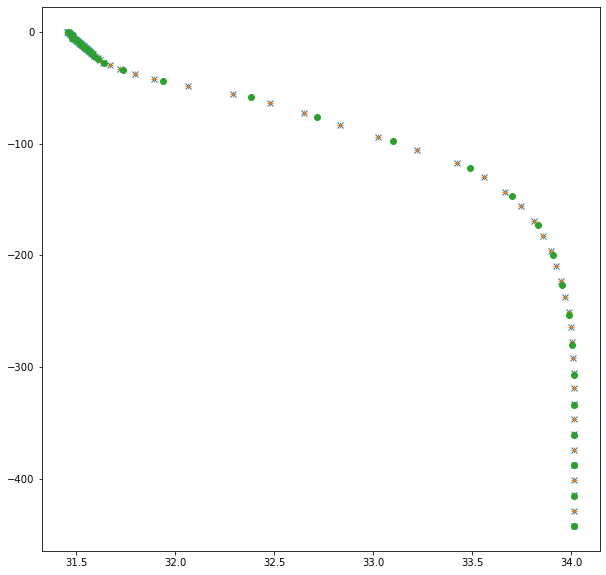

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(vosaline[:, 94*2], -deptht, 'x')
ax.plot(vosaline[:, 94*2+1], -deptht, '+')
ax.plot(single.vosaline[0, :, 0, 94], -odeptht, 'o');

In [38]:
vosaline = np.expand_dims(np.reshape(duplicate_interpolate(np.reshape(np.array(single.vosaline[0, :, 0, :]), [40, 95, 10], order='F'), 
                                                           zsize, xsize, ysize, ozsize, np.array(deptht), np.array(odeptht)), 
                                     [80, 1, 3800], order='F'),
                          axis=0)
vosaline.shape

(1, 80, 1, 3800)

In [5]:
def do_the_expansions(single, variables, zsize, ysize, xsize, ozsize, deptht, odeptht):
    interpl = {}
    for var in variables:
        interpl[var] = np.expand_dims(np.reshape(duplicate_interpolate(np.reshape(np.array(single[var][0, :, 0, :]), [40, 95, 10], order='F'), 
                                                           zsize, xsize, ysize, ozsize, np.array(deptht), np.array(odeptht)), 
                                     [80, 1, 3800], order='F'),
                          axis=0)
    return interpl

In [6]:
interpl = do_the_expansions(single, variables, zsize, xbTsize, ozsize, deptht, odeptht)

NameError: name 'single' is not defined

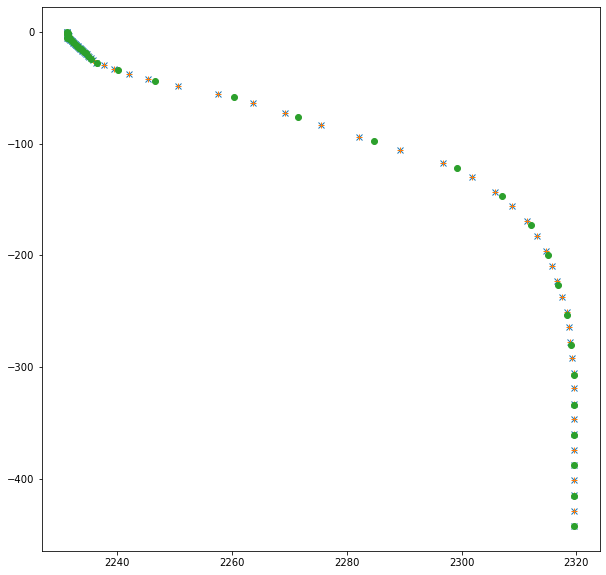

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(interpl['TA'][0, :, 0, 94*2], -deptht, 'x')
ax.plot(interpl['TA'][0, :, 0, 94*2+1], -deptht, '+')
ax.plot(single.TA[0, :, 0, 94], -odeptht, 'o');

In [7]:
def write_the_file(year, month, day, single, interpl, deptht, xbTsize):
    filename = f'ncfiles/LiveOcean/DLiveOcean_y{year}m{month:02d}d{day:02d}.nc'
    print (filename)
  # Add some global attributes
    ds_attrs = {
    'acknowledgements':
        'from LiveOcean courtesy Parker MacCready',
    'creator_email':
        'sallen@eoas.ubc.ca',
    'creator_name':
        'Salish Sea MEOPAR Project Contributors',
    'creator_url':
        'https://salishsea-meopar-docs.readthedocs.org/',
    'institution':
        'UBC EOAS',
    'institution_fullname': (
        'Earth, Ocean & Atmospheric Sciences,'
        ' University of British Columbia'
    ),
    'summary': (
        'Live Ocean File, doubled by depth interpolation from LiveOcean_v201905'
    ),
    'source': (
        'tools/double_resolution/West_OBC_LO.ipynb'
    ),
    'history': (
        '[{}] File creation.'
        .format(datetime.datetime.today().strftime('%Y-%m-%d'))
    )
    }  

    da = {}

    for var in interpl.keys():
 
        dims = ('time_counter', 'deptht', 'yb', 'xbT')
        coords = {'time_counter': single.time_counter, 'deptht': np.array(deptht), 'yb': [0], 'xbT': np.arange(xbTsize)}
        attrs = single[var].attrs

        da[var] = xr.DataArray(
            data=interpl[var],
            name=var,
            dims=dims,
            coords=coords,
            attrs=attrs
        )
    ds = xr.Dataset(
    data_vars=da,
    coords=coords,
    attrs=ds_attrs
    )
    encoding = {var: {'zlib': True} for var in ds.data_vars}
    ds.to_netcdf(
    path=filename,
    unlimited_dims=('time_counter'),
    encoding=encoding,
    )

In [43]:
write_the_file(year, month, day, single, interpl, deptht, xbTsize)

ncfiles/LiveOcean/DLiveOcean_y2017m01d027.nc


In [45]:
tester = xr.open_dataset('ncfiles/LiveOcean/DLiveOcean_y2017m01d027.nc')
tester

<xarray.Dataset>
Dimensions:       (deptht: 80, time_counter: 1, xbT: 3800, yb: 1)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-12-31T12:00:00
  * deptht        (deptht) float64 0.25 0.75 1.25 1.75 ... 414.5 428.2 441.8
  * yb            (yb) int64 0
  * xbT           (xbT) int64 0 1 2 3 4 5 6 ... 3794 3795 3796 3797 3798 3799
Data variables:
    vosaline      (time_counter, deptht, yb, xbT) float64 ...
    votemper      (time_counter, deptht, yb, xbT) float64 ...
    NO3           (time_counter, deptht, yb, xbT) float64 ...
    Si            (time_counter, deptht, yb, xbT) float64 ...
    OXY           (time_counter, deptht, yb, xbT) float64 ...
    DIC           (time_counter, deptht, yb, xbT) float64 ...
    TA            (time_counter, deptht, yb, xbT) float64 ...
Attributes:
    acknowledgements:      from LiveOcean courtesy Parker MacCready
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               Live Ocean File, doubled by depth interpolation fr...
    source:                tools/double_resolution/West_OBC_LO.ipynb
    history:               [2022-06-23] File creation.

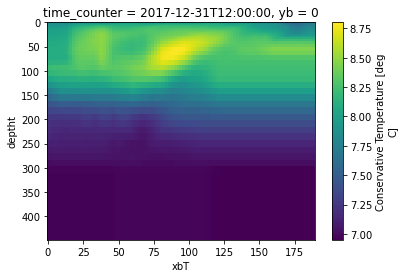

In [46]:
tester.votemper[0, :, 0, 0:190].plot(yincrease=False);

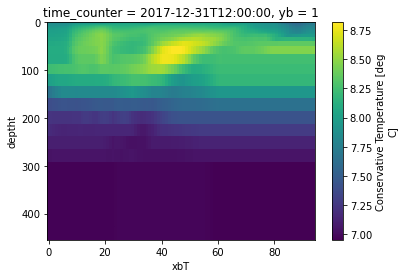

In [47]:
single.votemper[0, :, 0, 0:95].plot(yincrease=False);

## Now do the Looping over a Year

In [12]:
year = 2017
smonth = 1
emonth = 12
startdate = arrow.get(year, smonth, 1)
enddate = arrow.get(year, emonth, 31)
print (startdate, enddate)

2017-01-01T00:00:00+00:00 2017-12-31T00:00:00+00:00


Using the old mesh and new mesh files for deptht and odeptht as defined above  
And the definition of variables

In [13]:
for day in arrow.Arrow.range('day', startdate, enddate):
    singlefile = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y{day.year}m{day.month:02d}d{day.day:02d}.nc'
    single = xr.open_dataset(singlefile)
    
    ozsize = single.deptht.shape[0]
    zsize = 2*single.deptht.shape[0]
    tsize = single.time_counter.shape[0]
    xbTsize = 2*2*single.xbT.shape[0]
    ysize = int(single.xbT.shape[0]/10*2)
    xsize = 10*2
    
    interpl = do_the_expansions(single, variables, zsize, ysize, xsize, ozsize, deptht, odeptht)
    write_the_file(day.year, day.month, day.day, single, interpl, deptht, xbTsize)
    
    single.close()

ncfiles/LiveOcean/DLiveOcean_y2017m01d01.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d02.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d03.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d04.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d05.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d06.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d07.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d08.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d09.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d10.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d11.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d12.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d13.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d14.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d15.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d16.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d17.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d18.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d19.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d20.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d21.nc
ncfiles/LiveOcean/DLiveOcean_y2017m01d22.nc
ncfiles/LiveOcean/DLiveOcean_y20